In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#use command in shell to get data
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

/bin/bash: curl: command not found


In [ ]:
#use command in shell to unzip data
!unzip -q kagglecatsanddogs_3367a.zip
!ls

In [ ]:
#Check the directory
!ls PetImages

In [2]:
#Filter corrupted images
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("/home/becode/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [8]:
#Generate dataset
image_size = (180, 180)
batch_size = 32

#Load and preprocessing training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/becode/PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

#Load and preprocessing validation/test dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/becode/PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


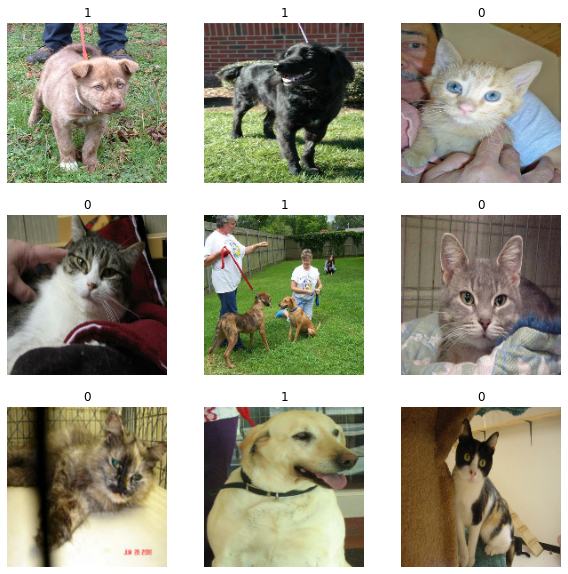

In [4]:
#Visualize data
import matplotlib.pyplot as plt

#Set figure size
plt.figure(figsize=(10, 10))

#Select 9 images from training dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        #convert array to image?
        plt.imshow(images[i].numpy().astype("uint8"))
        
        #show label for each image, dog = 1, cat = 0
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
#Data augumentation - basically flipping some images to increase the dataset size

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#Note there's two ways to use data augumentation
#include it as the first layer in the model (good for GPU)
#or apply it directly to the dataset in batches (good for CPU)

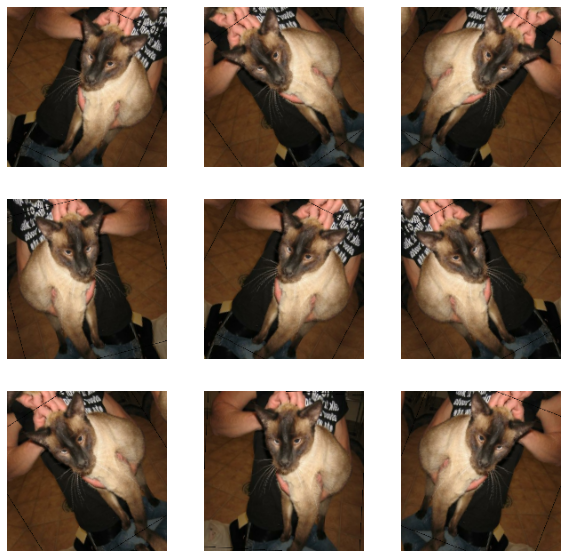

In [9]:
#Check the results of the data augmentation
plt.figure(figsize=(10, 10))


for images, _ in train_ds.take(1):

    #Select 9 images from dataset after data augmentation
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        
        #Convert array to image
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
#Configure the dataset performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

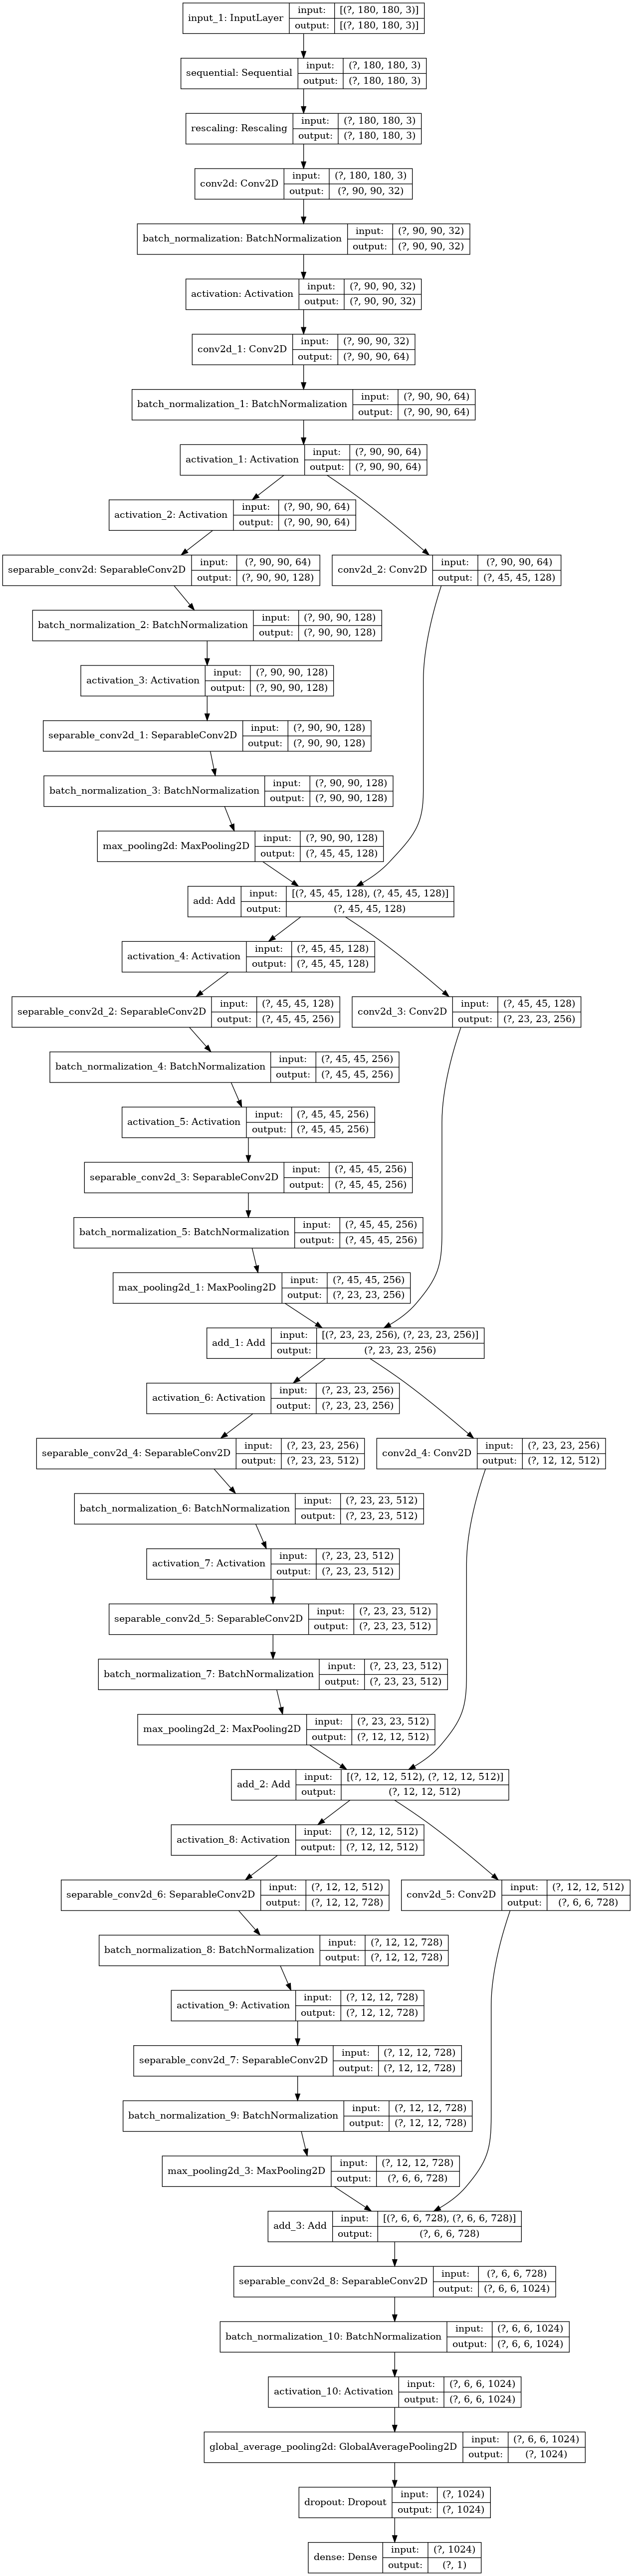

In [7]:
#Build model 
def make_model(input_shape, num_classes):
    #Specify input shape (3D array representing an image, [180, 180, 1], rows, columns, channels.
    inputs = keras.Input(shape=input_shape)
    
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    #Rescale image from [0, 255] to [0, 1]
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    
    #Apply 2D convaluted layer, 32 filters, 3 kernal size (height/width of convolution window), 2 strides in height/width of convolution window, 
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    #Add dropout layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [8]:
#Train the model
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 4974s 8s/step - loss: 0.6121 - accuracy: 0.6785 - val_loss: 0.6338 - val_accuracy: 0.6405
Epoch 2/50
586/586 [==============================] - 3545s 6s/step - loss: 0.4579 - accuracy: 0.7867 - val_loss: 0.4820 - val_accuracy: 0.8016
Epoch 3/50
586/586 [==============================] - 3552s 6s/step - loss: 0.3574 - accuracy: 0.8432 - val_loss: 0.4155 - val_accuracy: 0.8471
Epoch 4/50
586/586 [==============================] - 3963s 7s/step - loss: 0.3074 - accuracy: 0.8668 - val_loss: 0.4934 - val_accuracy: 0.7819
Epoch 5/50
586/586 [==============================] - 4642s 8s/step - loss: 0.2607 - accuracy: 0.8920 - val_loss: 0.2292 - val_accuracy: 0.9020
Epoch 6/50
586/586 [==============================] - 4063s 7s/step - loss: 0.2159 - accuracy: 0.9089 - val_loss: 0.8846 - val_accuracy: 0.7460
Epoch 7/50
586/586 [==============================] - 3701s 6s/step - loss: 0.1948 - accuracy: 0.9189 - val_loss: 0.3830 - val_accuracy:

In [10]:
#Run inference on new data
img = keras.preprocessing.image.load_img(
    "/home/becode/PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 79.73 percent cat and 20.27 percent dog.


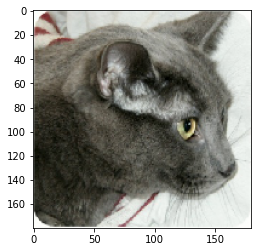

In [20]:
img_array = keras.preprocessing.image.img_to_array(img)
img = keras.preprocessing.image.load_img(
    "/home/becode/PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)
#plt.imshow(augmented_images[0].numpy().astype("uint8"))

In [48]:
dir(model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compiled_tr

In [17]:
model_h5 = tf.keras.models.load_model('model.h5')

In [39]:
#Reload model
model_h5 = tf.keras.models.load_model('model.h5')

In [40]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [41]:
print(tf.executing_eagerly())

False


In [31]:
from PIL import Image 
  
# open method used to open different extension image file 
img = Image.open(r"/home/becode/PetImages/Cat/6779.jpg")  
img = img.resize((180, 180))
# This method will show image in any image viewer  
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_h5.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 67.68 percent cat and 32.32 percent dog.
